In [2]:
import pandas as pd
from google.cloud import bigquery
import os
from dotenv import load_dotenv

In [3]:
load_dotenv()
PROJECT_ID = os.getenv('GCP_PROJECT_ID')
client = bigquery.Client(project=PROJECT_ID)

### Batters

In [5]:
query = """
SELECT
    season,
    name,
    team,
    ops,
    iso,
    (100 * so / pa) AS k_rate,
    (100 * bb / pa) AS bb_rate,
    pa,
    ab
FROM `tksm-dash-test-25.mlb_analytics_dash_25.fact_batting_stats_with_risp`
WHERE season = 2025
    AND pa >= 300
ORDER BY ops DESC
"""

df = client.query(query).to_dataframe()
print(f"Number of eligible players: {len(df)}")
df.head()

Number of eligible players: 243


c:\Users\inthe\Desktop\Python_scripts_2025\diamond-lens\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,season,name,team,ops,iso,k_rate,bb_rate,pa,ab
0,2025,Aaron Judge,NYY,1.144,0.357,23.564065,18.262150,679,541
1,2025,Shohei Ohtani,LAD,1.014,0.340,25.722146,14.993122,727,611
2,2025,George Springer,TOR,0.959,0.251,18.941980,11.774744,586,498
3,2025,Cal Raleigh,SEA,0.948,0.342,26.666667,13.758865,705,596
4,2025,Ronald Acuna Jr.,ATL,0.935,0.228,24.757282,17.233010,412,338


In [ ]:
# 欠損値チェック
print(df.isnull().sum())

season     0
name       0
team       0
ops        0
iso        0
k_rate     0
bb_rate    0
pa         0
ab         0
dtype: int64


In [8]:
# 基本統計量
df[['ops', 'iso', 'k_rate', 'bb_rate']].describe()

,ops,iso,k_rate,bb_rate
count,243.000000,243.000000,243.000000,243.000000
mean,0.740975,0.166671,21.310945,8.635922
std,0.085730,0.052951,5.808585,2.994537
min,0.535000,0.030000,3.111111,2.288330
25%,0.684000,0.131000,17.383664,6.347554
50%,0.735000,0.167000,21.516755,8.245877
75%,0.795000,0.192500,25.300034,10.675300
max,1.144000,0.357000,39.169139,18.262150


#### K-means clustering

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = ['ops', 'iso', 'k_rate', 'bb_rate']
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Number of players in each cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)

cluster
0    76
1    83
2    21
3    63
Name: count, dtype: int64


In [10]:
cluster_summary = df.groupby('cluster')[features].mean()
print(cluster_summary)

              ops       iso     k_rate    bb_rate
cluster                                          
0        0.762816  0.200513  25.838417   8.348757
1        0.751952  0.148928  15.918535   8.989832
2        0.893333  0.249810  23.006570  14.049154
3        0.649381  0.121508  22.388311   6.711668


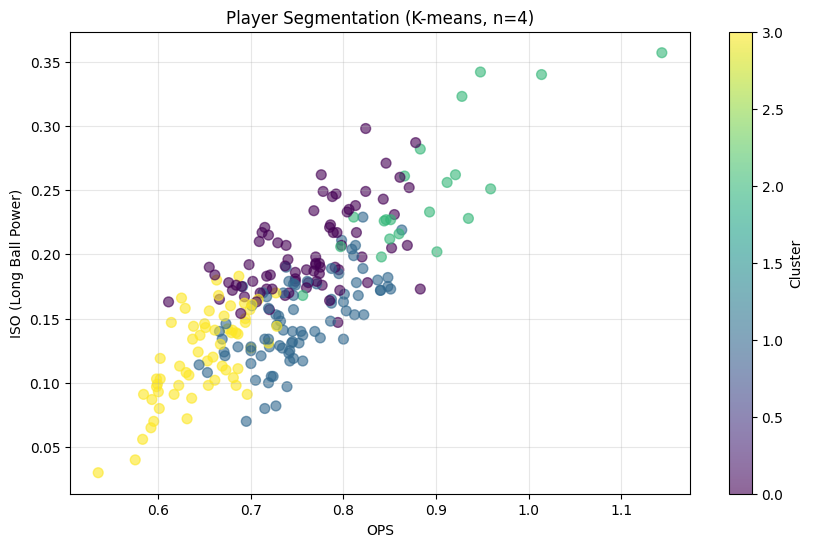

In [11]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['ops'], df['iso'], c=df['cluster'], cmap='viridis', s=50, alpha=0.6)
plt.xlabel('OPS')
plt.ylabel('ISO (Long Ball Power)')
plt.title('Player Segmentation (K-means, n=4)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Top 3 players in each cluster
for cluster_id in range(4):
    print(f"\n=== Cluster {cluster_id} ===")
    cluster_players = df[df['cluster'] == cluster_id].nlargest(3, 'ops')
    print(cluster_players[['name', 'team', 'ops', 'iso', 'k_rate', 'bb_rate']])
    


=== Cluster 0 ===
               name team    ops    iso     k_rate   bb_rate
11  Jonathan Aranda  TBR  0.883  0.173  25.355450  9.715640
12     Byron Buxton  MIN  0.878  0.287  27.306273  7.564576
13      Pete Alonso  NYM  0.871  0.252  22.849083  8.603667

=== Cluster 1 ===
               name team    ops    iso     k_rate    bb_rate
16     Jose Ramirez  CLE  0.863  0.219  10.995542   9.806835
21  Geraldo Perdomo  ARI  0.851  0.173  11.527778  13.055556
24       Yandy Diaz  TBR  0.848  0.182  14.132104   8.755760

=== Cluster 2 ===
              name team    ops    iso     k_rate    bb_rate
0      Aaron Judge  NYY  1.144  0.357  23.564065  18.262150
1    Shohei Ohtani  LAD  1.014  0.340  25.722146  14.993122
2  George Springer  TOR  0.959  0.251  18.941980  11.774744

=== Cluster 3 ===
                 name team    ops    iso     k_rate   bb_rate
129      Heliot Ramos  SFG  0.728  0.144  22.733813  7.482014
130        Lenyn Sosa  CHW  0.727  0.170  23.345588  3.308824
140  Jasson Do

In [14]:
cluster_labels = {
    0: "Solid Regular Hitters",
    1: "Elite Contact Hitters",
    2: "Super Elite Sluggers",
    3: "Struggling Hitters"
}

df['cluster_name'] = df['cluster'].map(cluster_labels)

### Pitchers

In [29]:
query_pitchers = """
SELECT
    season,
    name,
    team,
    era,
    whip,
    avg AS batting_average_against,
    k_9,
    bb_9,
    hr_9,
    gbpct,
    fbpct,
    ip,
    gs
FROM `tksm-dash-test-25.mlb_analytics_dash_25.fact_pitching_stats_master`
WHERE season  = 2025
    AND gs > 0 AND ip > 90 -- only starting pitchers
ORDER BY era ASC
"""

df_pitchers = client.query(query_pitchers).to_dataframe()
print(f"Number of eligible players: {len(df_pitchers)}")
df_pitchers.head()

Number of eligible players: 118


c:\Users\inthe\Desktop\Python_scripts_2025\diamond-lens\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,season,name,team,era,whip,batting_average_against,k_9,bb_9,hr_9,gbpct,fbpct,ip,gs
0,2025,Nathan Eovaldi,TEX,1.73,0.85,0.192,8.93,1.45,0.69,0.503,0.313,130.0,22
1,2025,Trevor Rogers,BAL,1.81,0.90,0.179,8.45,2.38,0.49,0.460,0.382,109.2,18
2,2025,Tarik Skubal,DET,2.21,0.89,0.199,11.10,1.52,0.83,0.410,0.384,195.1,31
3,2025,Hunter Brown,HOU,2.43,1.03,0.200,10.00,2.77,0.83,0.481,0.326,185.1,31
4,2025,Yoshinobu Yamamoto,LAD,2.49,0.99,0.182,10.42,3.06,0.73,0.528,0.312,173.2,30


In [36]:
df_pitchers[['era', 'whip', 'k_9', 'gbpct']].describe()

,era,whip,k_9,gbpct
count,118.000000,118.000000,118.000000,118.000000
mean,4.025593,1.246780,8.225932,0.417254
std,1.002884,0.170669,1.568707,0.069095
min,1.730000,0.850000,5.050000,0.275000
25%,3.335000,1.117500,7.050000,0.372250
50%,4.010000,1.270000,8.080000,0.411000
75%,4.640000,1.345000,9.335000,0.455500
max,6.700000,1.840000,11.890000,0.653000


#### K-means clustering

In [56]:
pitcher_features = ['era', 'k_9', 'gbpct']
X_pitchers = df_pitchers[pitcher_features]

# Standardize features
scaler = StandardScaler()
X_pitchers_scaled = scaler.fit_transform(X_pitchers)

# K-means (n=4)
kmeans_pitchers = KMeans(n_clusters=4, random_state=42)
df_pitchers['cluster'] = kmeans_pitchers.fit_predict(X_pitchers_scaled)

print(df_pitchers['cluster'].value_counts().sort_index())

cluster
0    25
1    27
2    33
3    33
Name: count, dtype: int64


In [57]:
pitcher_cluster_summary = df_pitchers.groupby('cluster')[pitcher_features].mean()
print(pitcher_cluster_summary.round(2))

          era   k_9  gbpct
cluster                   
0        3.22  8.23   0.51
1        5.39  7.52   0.40
2        3.49  9.97   0.38
3        4.05  7.06   0.39


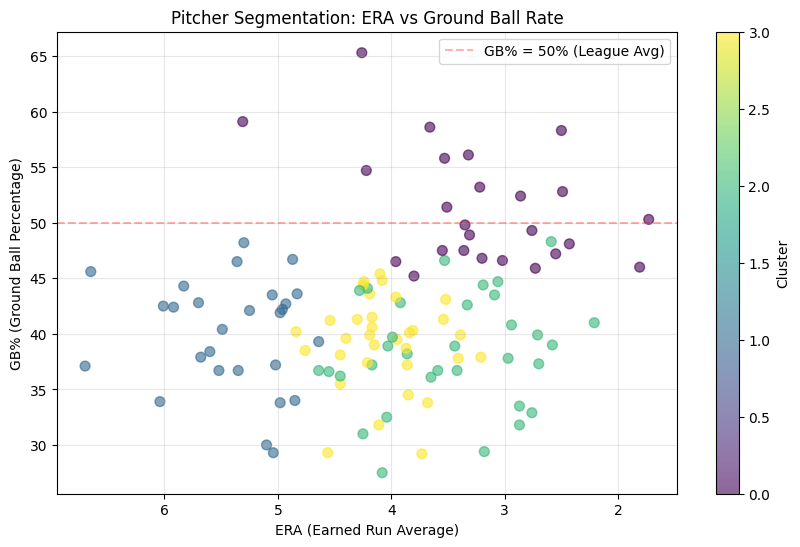

In [58]:
# Visualize clusters 2 dimensional
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pitchers['era'], df_pitchers['gbpct']*100, 
                     c=df_pitchers['cluster'], cmap='viridis', s=50, alpha=0.6)
plt.xlabel('ERA (Earned Run Average)')
plt.ylabel('GB% (Ground Ball Percentage)')
plt.title('Pitcher Segmentation: ERA vs Ground Ball Rate')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()  # ERA低い方が左（優秀）
plt.axhline(y=50, color='red', linestyle='--', alpha=0.3, label='GB% = 50% (League Avg)')
plt.legend()
plt.show()

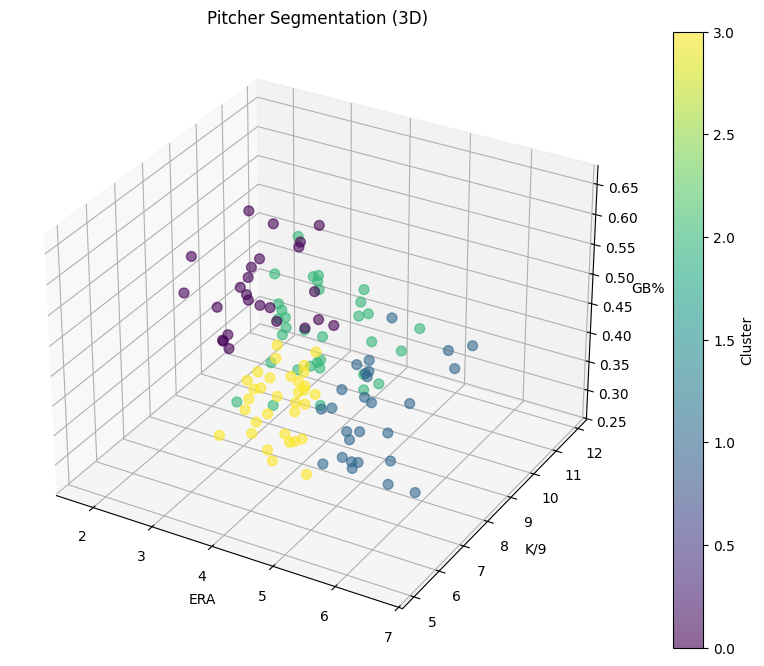

In [59]:
# Visualize clusters 3 dimensional
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pitchers['era'], 
                     df_pitchers['k_9'], 
                     df_pitchers['gbpct'],
                     c=df_pitchers['cluster'], 
                     cmap='viridis', s=50, alpha=0.6)

ax.set_xlabel('ERA')
ax.set_ylabel('K/9')
ax.set_zlabel('GB%')
ax.set_title('Pitcher Segmentation (3D)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [60]:
for cluster_id in range(4):
    print(f"\n{'='*60}")
    print(f"=== Cluster {cluster_id} ===")
    print(f"{'='*60}")
    cluster_pitchers = df_pitchers[df_pitchers['cluster'] == cluster_id].nsmallest(4, 'era')
    print(cluster_pitchers[['name', 'team', 'era', 'k_9', 'bb_9', 'hr_9', 'whip', 'gbpct', 'ip']].to_string(index=False))


=== Cluster 0 ===
              name team  era   k_9  bb_9  hr_9  whip  gbpct    ip
    Nathan Eovaldi  TEX 1.73  8.93  1.45  0.69  0.85  0.503 130.0
     Trevor Rogers  BAL 1.81  8.45  2.38  0.49  0.90  0.460 109.2
      Hunter Brown  HOU 2.43 10.00  2.77  0.83  1.03  0.481 185.1
Yoshinobu Yamamoto  LAD 2.49 10.42  3.06  0.73  0.99  0.528 173.2

=== Cluster 1 ===
            name   team  era  k_9  bb_9  hr_9  whip  gbpct    ip
Michael Lorenzen    KCR 4.64 8.07  2.48  1.59  1.33  0.393 141.2
      Zac Gallen    ARI 4.83 8.20  3.09  1.45  1.26  0.436 192.0
    Aaron Civale TRADED 4.85 7.76  2.91  1.41  1.26  0.340 102.0
       Shane Baz    TBR 4.87 9.52  3.46  1.41  1.33  0.467 166.1

=== Cluster 2 ===
           name team  era   k_9  bb_9  hr_9  whip  gbpct    ip
   Tarik Skubal  DET 2.21 11.10  1.52  0.83  0.89  0.410 195.1
     Chris Sale  ATL 2.58 11.82  2.29  0.79  1.07  0.390 125.2
Garrett Crochet  BOS 2.59 11.18  2.02  1.05  1.03  0.483 205.1
 Freddy Peralta  MIL 2.70 10.39  3.3

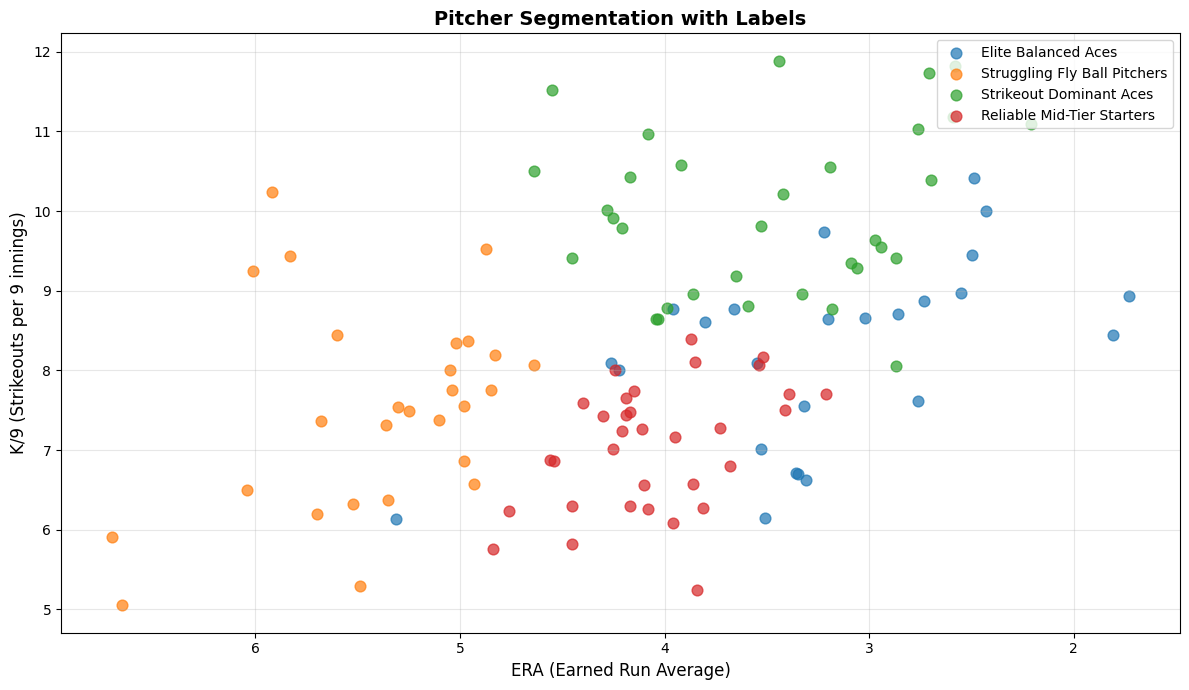

In [61]:
cluster_labels = {
    0: "Elite Balanced Aces",
    1: "Struggling Fly Ball Pitchers",
    2: "Strikeout Dominant Aces",
    3: "Reliable Mid-Tier Starters"
}

df_pitchers['cluster_name'] = df_pitchers['cluster'].map(cluster_labels)

plt.figure(figsize=(12, 7))
for cluster_id in range(4):
    cluster_data = df_pitchers[df_pitchers['cluster'] == cluster_id]
    plt.scatter(cluster_data['era'], cluster_data['k_9'], 
                label=cluster_labels[cluster_id], s=60, alpha=0.7)

plt.xlabel('ERA (Earned Run Average)', fontsize=12)
plt.ylabel('K/9 (Strikeouts per 9 innings)', fontsize=12)
plt.title('Pitcher Segmentation with Labels', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()  # ERA低い方が左
plt.tight_layout()
plt.show()